In [1]:
%matplotlib inline


Compile Tensorflow Models
=========================
This article is an introductory tutorial to deploy tensorflow models with TVM.

For us to begin with, tensorflow python module is required to be installed.

Please refer to https://www.tensorflow.org/install



In [2]:
# tvm, relay
import tvm
from tvm import te
from tvm import relay

# os and numpy
import numpy as np
import os.path

# Tensorflow imports
import tensorflow as tf

try:
    tf_compat_v1 = tf.compat.v1
except ImportError:
    tf_compat_v1 = tf

# Tensorflow utility functions
import tvm.relay.testing.tf as tf_testing

# Base location for model related files.
repo_base = "https://github.com/dmlc/web-data/raw/master/tensorflow/models/InceptionV1/"

# Test image
img_name = "elephant-299.jpg"
image_url = os.path.join(repo_base, img_name)

Tutorials
---------
Please refer docs/frontend/tensorflow.md for more details for various models
from tensorflow.



In [6]:
model_name = "classify_image_graph_def-with_shapes.pb"
model_url = os.path.join(repo_base, model_name)

# Image label map
map_proto = "imagenet_2012_challenge_label_map_proto.pbtxt"
map_proto_url = os.path.join(repo_base, map_proto)

# Human readable text for labels
label_map = "imagenet_synset_to_human_label_map.txt"
label_map_url = os.path.join(repo_base, label_map)

# Target settings
# Use these commented settings to build for cuda.
# target = 'cuda'
# target_host = 'llvm'
# layout = "NCHW"
# ctx = tvm.gpu(0)
target = "llvm"
target_host = "llvm"
layout = None
ctx = tvm.cpu(0)


Download required files
-----------------------
Download files listed above.



In [9]:
from tvm.contrib.download import download_testdata

img_path = download_testdata(image_url, img_name, module="data")
model_path = download_testdata(model_url, model_name, module=["tf", "InceptionV1"])
map_proto_path = download_testdata(map_proto_url, map_proto, module="data")
label_path = download_testdata(label_map_url, label_map, module="data")

File /Users/wanglei/.tvm_test_data/data/elephant-299.jpg exists, skip.
File /Users/wanglei/.tvm_test_data/tf/InceptionV1/classify_image_graph_def-with_shapes.pb exists, skip.
File /Users/wanglei/.tvm_test_data/data/imagenet_2012_challenge_label_map_proto.pbtxt exists, skip.
File /Users/wanglei/.tvm_test_data/data/imagenet_synset_to_human_label_map.txt exists, skip.


Import model
------------
Creates tensorflow graph definition from protobuf file.



In [10]:
with tf_compat_v1.gfile.GFile(model_path, "rb") as f:
    graph_def = tf_compat_v1.GraphDef()
    graph_def.ParseFromString(f.read())
    graph = tf.import_graph_def(graph_def, name="")
    # Call the utility to import the graph definition into default graph.
    graph_def = tf_testing.ProcessGraphDefParam(graph_def)
    # Add shapes to the graph.
    with tf_compat_v1.Session() as sess:
        graph_def = tf_testing.AddShapesToGraphDef(sess, "softmax")

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 0 variables.
INFO:tensorflow:Converted 0 variables to const ops.


Decode image
------------
<div class="alert alert-info"><h4>Note</h4><p>tensorflow frontend import doesn't support preprocessing ops like JpegDecode.
  JpegDecode is bypassed (just return source node).
  Hence we supply decoded frame to TVM instead.</p></div>




In [11]:
from PIL import Image

image = Image.open(img_path).resize((299, 299))

x = np.array(image)

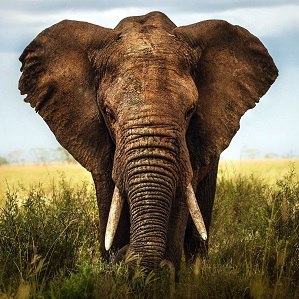

In [14]:
image

Import the graph to Relay
-------------------------
Import tensorflow graph definition to relay frontend.

Results:
  sym: relay expr for given tensorflow protobuf.
  params: params converted from tensorflow params (tensor protobuf).



In [ ]:
shape_dict = {"DecodeJpeg/contents": x.shape}
dtype_dict = {"DecodeJpeg/contents": "uint8"}
mod, params = relay.frontend.from_tensorflow(graph_def, layout=layout, shape=shape_dict)

print("Tensorflow protobuf imported to relay frontend.")

Relay Build
-----------
Compile the graph to llvm target with given input specification.

Results:
  graph: Final graph after compilation.
  params: final params after compilation.
  lib: target library which can be deployed on target with TVM runtime.



In [ ]:
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, target_host=target_host, params=params)

Execute the portable graph on TVM
---------------------------------
Now we can try deploying the compiled model on target.



In [ ]:
from tvm.contrib import graph_runtime

dtype = "uint8"
m = graph_runtime.GraphModule(lib["default"](ctx))
# set inputs
m.set_input("DecodeJpeg/contents", tvm.nd.array(x.astype(dtype)))
# execute
m.run()
# get outputs
tvm_output = m.get_output(0, tvm.nd.empty(((1, 1008)), "float32"))

Process the output
------------------
Process the model output to human readable text for InceptionV1.



In [ ]:
predictions = tvm_output.asnumpy()
predictions = np.squeeze(predictions)

# Creates node ID --> English string lookup.
node_lookup = tf_testing.NodeLookup(label_lookup_path=map_proto_path, uid_lookup_path=label_path)

# Print top 5 predictions from TVM output.
top_k = predictions.argsort()[-5:][::-1]
for node_id in top_k:
    human_string = node_lookup.id_to_string(node_id)
    score = predictions[node_id]
    print("%s (score = %.5f)" % (human_string, score))

Inference on tensorflow
-----------------------
Run the corresponding model on tensorflow



In [ ]:
def create_graph():
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf_compat_v1.gfile.GFile(model_path, "rb") as f:
        graph_def = tf_compat_v1.GraphDef()
        graph_def.ParseFromString(f.read())
        graph = tf.import_graph_def(graph_def, name="")
        # Call the utility to import the graph definition into default graph.
        graph_def = tf_testing.ProcessGraphDefParam(graph_def)


def run_inference_on_image(image):
    """Runs inference on an image.

    Parameters
    ----------
    image: String
        Image file name.

    Returns
    -------
        Nothing
    """
    if not tf_compat_v1.gfile.Exists(image):
        tf.logging.fatal("File does not exist %s", image)
    image_data = tf_compat_v1.gfile.GFile(image, "rb").read()

    # Creates graph from saved GraphDef.
    create_graph()

    with tf_compat_v1.Session() as sess:
        softmax_tensor = sess.graph.get_tensor_by_name("softmax:0")
        predictions = sess.run(softmax_tensor, {"DecodeJpeg/contents:0": image_data})

        predictions = np.squeeze(predictions)

        # Creates node ID --> English string lookup.
        node_lookup = tf_testing.NodeLookup(
            label_lookup_path=map_proto_path, uid_lookup_path=label_path
        )

        # Print top 5 predictions from tensorflow.
        top_k = predictions.argsort()[-5:][::-1]
        print("===== TENSORFLOW RESULTS =======")
        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print("%s (score = %.5f)" % (human_string, score))


run_inference_on_image(img_path)